# 3. Routing / Supervisor

In [1]:
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from typing import Literal

In [2]:
llm = AzureChatOpenAI(model="gpt-4.1-mini")

In [3]:
from pydantic import BaseModel

class RouterOutput(BaseModel):
    """Output of the router, indicating which tool to use. Set to 'unknown' if no tool is applicable."""
    tool: Literal["joke", "unknown"]

In [4]:
def router(state) -> Literal["joke", "unknown"]:
    structured_llm = llm.bind_tools(tools = [RouterOutput], tool_choice="required")
    response = structured_llm.invoke(input=state["messages"])
    output = RouterOutput(**response.tool_calls[0]["args"])
    return output.tool


In [5]:
def joke_generator(state) -> str:
    print("Node: Joke")
    response = llm.invoke(input=state["messages"])

    return {
        "messages": [response]
    }

In [6]:
def unknown_node(state):
    print("Node: Unknown")
    return {
        "messages": [
            AIMessage(content="I don't have the information you need. Please try asking something else.")
        ]
    }

In [7]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

builder = StateGraph(MessagesState)

builder.add_node("joke", joke_generator)
builder.add_node("unknown", unknown_node)

builder.add_conditional_edges(START, router)
builder.add_edge("joke", END)
builder.add_edge("unknown", END)

graph = builder.compile()

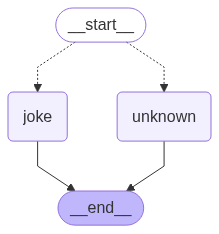

In [8]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [9]:
response = graph.invoke(
    input= {"messages": [
        SystemMessage(
            content="You are a helpful assistant that can provide weather information for specific cities."
        ),
        HumanMessage(
            content="Tell me a joke about Perth"
        )
    ]}
)

print(response["messages"][-1].content)

Node: Joke
Sure! Here's a light-hearted joke about Perth:

Why don’t secrets last long in Perth?

Because even the wind is Western!
